<img style="float:right;" src="https://data.iflood.vse.gmu.edu/Forecast/ChesapeakeBay_XBEACH/pics_for_deal/labLogoFLOOD_black.png" width=300px>  
# XBeach


Introduction
============

XBeach is an open-source numerical model which is originally developed
to simulate hydrodynamic and morphodynamic processes and impacts on
sandy coasts with a domain size of kilometers and on the time scale of
storms. Since then, the model has been applied to other types of
coasts and purposes.

The model includes the hydrodynamic processes of short wave
transformation (refraction, shoaling and breaking), long wave
(infragravity wave) transformation (generation, propagation and
dissipation), wave-induced setup and unsteady currents, as well as
overwash and inundation. The morphodynamic processes include bed load
and suspended sediment transport, dune face avalanching, bed update
and breaching. Effects of vegetation and of hard structures have been
included. The model has been validated with a series of analytical,
laboratory and field test cases using a standard set of parameter
settings.

Hydrodynamics options
---------------------

XBeach was originally developed as a short-wave averaged but wave-group
resolving model, allowing resolving the short wave variations on the
wave group scale and the long waves associated with them. Since the
original paper by `Roelvink2009` a number of additional model
options have been implemented, thereby allowing users to choose which
time-scales to resolve:  

 - Stationary wave model (keyword: `wavemodel` = *stationary*),
   efficiently solving wave-averaged equations but neglecting
   infragravity waves;   

 - Surfbeat mode (instationary) (keyword: `wavemodel` =
   *surfbeat*), where the short wave variations on the wave group
   scale (short wave envelope) and the long waves associated with them
   are resolved;   

 - Non-hydrostatic mode (wave-resolving) (keyword: `wavemodel` = *nonh*), where a combination of the non-linear shallow water equations with a pressure correction term is applied, allowing to model the propagation and decay of individual waves.  


In [1]:
import sys;sys.path.append('../xbeach/')
from importlib import reload
from libs import *

In [2]:
root = pl.Path(r'Z:\Users\Tyler\projects\TNC\modeling\2d')
xb = nc4.Dataset(str(root / 'opt3' / 'xboutput.nc'))
root2 = pl.Path(r'Z:\Project_TNC\3_Field\2_Data\2_Processed')
hobos = root2 / '1_hobo' / 'di_20180912_20181205'

#### Initialize Variables

In [3]:
x,y = xbeach.utm2geo(xb.variables['globalx'][:],xb.variables['globaly'][:])
z = xb.variables['zb'][:]
t = xb.variables['meantime'][:]
zs = xb.variables['zs'][:]
h = xb.variables['H'][:]
u = xb.variables['u'][:]
v = xb.variables['v'][:]

Grid set-up  
===========

The grid applied is a staggered grid, where the bed levels, water
levels, water depths and concentrations are defined in cell centers, and
velocities and sediment transports are defined in u- and v-points, viz.
at the cell interfaces. In the wave energy balance, the energy, roller
energy and radiation stress are defined at the cell centers, whereas the
radiation stress gradients are defined at u- and v-points.

Velocities at the u- and v-points are denoted by the output variables uu
and vv respectively; velocities u and v at the cell centers are obtained
by interpolation and are for output purpose only. The water level, zs,
and the bed level, zb, are both defined positive upward. uv and vu are
the u-velocity at the v-grid point and the v-velocity at the u-grid
point respectively. These are obtained by interpolation of the values of
the velocities at the four surrounding grid points.

The model solves coupled 2D horizontal equations for wave propagation,
flow, sediment transport and bottom changes, for varying (spectral) wave
and flow boundary conditions.

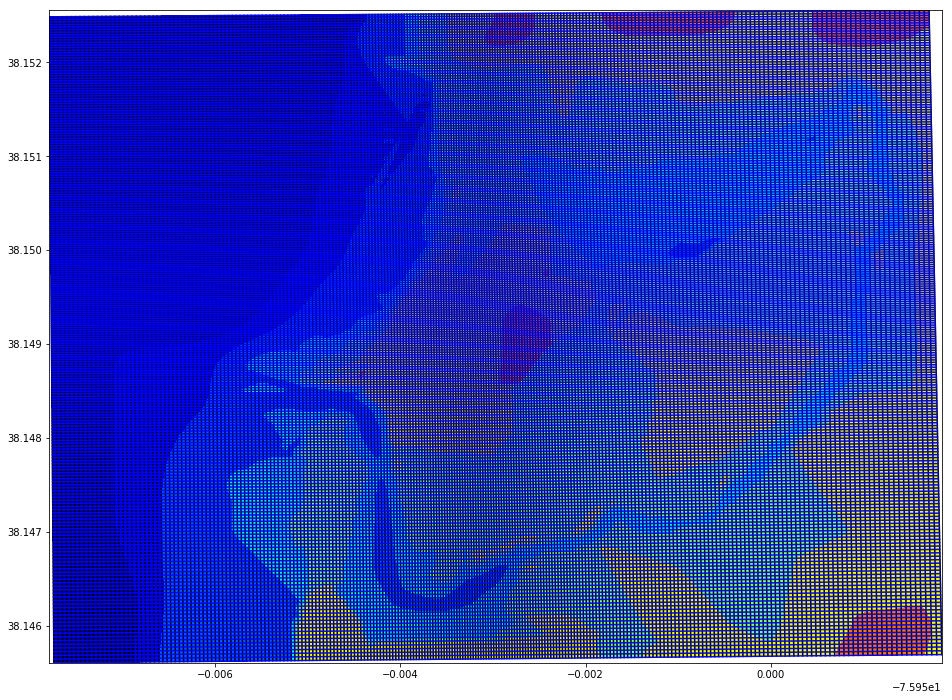

In [4]:
fig,ax = plt.subplots(figsize=(16,12))
ax.plot(x,y,'k')
ax.plot(x.transpose(),y.transpose(),'b')
ax.contourf(x,y,z[0,:,:],cmap='jet',vmin=-1.5,vmax=2)
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])
plt.show()

In [26]:
import xbeach_inputs
reload(xbeach_inputs)
import xbeach_inputs as xbi
from xbeach import *

In [5]:
xx,yy = x.shape
vege = np.zeros((xx,yy))
bed  = np.zeros((xx,yy))
z0 = z[0,:,:]
mannings = [0.027,0.02,0.025,0.100]#channel,ocean,marsh, tree
v_heights = [1,2,3,0]#marsh,beach,tress,none
x1,y1 = x.shape
for i in range(0,x1):
    for ii in range(0,y1):
        if z0[i,ii]<-.01 and x[i,ii]>-75.955 and y[i,ii]<38.1485:
            bed[i,ii] = mannings[0]
        elif .05 < z0[i,ii] < 0.6 and -75.955 < x[i,ii] < -75.954 and 38.1487<y[i,ii]<38.1495:
            vege[i,ii] = v_heights[1]
        elif z0[i,ii]<-.01 and x[i,ii]>-75.95325:
            bed[i,ii] = mannings[0]
        elif -0.05<z0[i,ii]<0.7 and x[i,ii]>-75.955:
            bed[i,ii] = mannings[2]
            vege[i,ii]=v_heights[0]
        elif z0[i,ii]>0.7:
            bed[i,ii] = mannings[3]
            vege[i,ii]=v_heights[2]
        else:
            bed[i,ii] = mannings[1]
            vege[i,ii]=v_heights[3]

xbi.write_2delft(root,vege,'temp.txt')
xbi.write_2delft(root,bed,'bedfrict.txt')

Dissipation
===========

In XBeach there are three short wave dissipation processes that can be
accounted for: wave breaking ({D}_{w}), bottom friction
({D}_{f}) and vegetation ({D}_{v}). The three
processes are explained in more detail in the following subsections.

#### Wave breaking

.. seealso:: Short wave dissipation by breaking is implemented
             in `mod:roelvink_module`.
             
Five different wave breaking formulations are implemented in XBeach. The
formulations can be selected using the keyword `break`.

##### Different wave breaking formulations implemented

   
   | Wave breaking formula       | Type of waves   | keyword          |
   |:---------------------------:|:---------------:|:----------------:|
   | Roelvink (1993a)            | Instationary    | roelvink1        |
   | Roelvink (1993a) extended   | Instationary    | roelvink2        |
   | Daly et al. (2010)          | Instationary    | roelvink_daly    |
   | Baldock et al. (1998)       | Stationary      | baldock          |
   | Janssen & Battjes (2007)    | Stationary      | janssen          |

For the surf beat approach the total wave energy dissipation, i.e.
directionally integrated, due to wave breaking can be modeled
according to `Roelvink1993a` (keyword:`break` =
*roelvink1*). In the formulation of the dissipation due to wave
breaking the idea is to calculate the dissipation with a fraction of
breaking waves (`{Q}_{b}`) multiplied by the dissipation per
breaking event. In this formulation `\alpha` is applied as wave
dissipation coefficient of O (keyword:`alpha`),
`{T}_{rep}` is the representative wave period and
`{E}_{w}` is the energy of the wave. The fraction of wave
breaking is determined with the root-mean-square wave height
(`{H}_{rms}`) and the maximum wave height
(`{H}_{max}`). The maximum wave height is calculated as ratio of
the water depth (`h`) plus a fraction of the wave height
(`\delta H_{rms}`, keyword:`delta`) using a breaker index
`\gamma` (keyword:`gamma`). In the formulation for
`{H}_{rms}` the `\rho` represents the water density and `g`
the gravitational constant. The total wave energy `{E}_{w}` is
calculated by integrating over the wave directional bins.

   wave-breaking-roelvink1
\begin{array}{c} {\bar{D}_{w} =2\frac{\alpha }{T_{rep} } Q_{b} E_{w} {\; }} \\ {Q_{b} {=1-exp}\left(-\left(\frac{H_{rms} }{H_{\max } } \right)^{n} \right),\quad H_{rms} =\sqrt{\frac{8E_{w} }{\rho g} } ,\quad H_{\max } =\gamma \cdot (h+\delta H_{rms} )} \\ {E_{w} (x,y,t)=\int _{0}^{2\pi }S_{w} (x,y,t,\theta )d\theta  } \end{array}


Vegetation
==========

The presence of aquatic vegetation within the area of wave propagation
or wave breaking results in an additional dissipation mechanism for
short waves. This is modeled using the approach of `Mendez2004a`,
which was adjusted by `Suzuki2012` to take into account
vertically heterogeneous vegetation, see `VanRooijen2015`. The
short wave dissipation due to vegetation is calculated as function of
the local wave height and several vegetation parameters. The vegetation
can be schematized in a number of vertical elements with each specific
property. In this way the wave damping effect of vegetation such as
mangrove trees, with a relatively dense root system but sparse stem
area, can be modeled. The dissipation term is then computed as the sum
of the dissipation per vegetation layer (`Suzuki2012`):


\begin{array}D_{v} =\sum _{i=1}^{n_{v} }D_{v,i} \end{array}

where :math:`{D}_{v,i}` is the dissipation by
vegetation in vegetation layer :math:`i` and :math:`{n}_{v}` is the number
of vegetation layers. The dissipation per layer is given by:

.. math::
   :label:

   \begin{array}{l} {D_{v,i} =A_{v} \cdot \frac{\rho \widetilde{C}_{D,i} b_{v,i} N_{v,i} }{2\sqrt{\pi } } \left(\frac{kg}{2\sigma } \right)^{3} H_{rms} ^{3} ,{\; with}} \\ {A_{v} =\frac{\left(\sinh ^{3} k\alpha _{i} h-\sinh ^{3} k\alpha _{i-1} h\right)+3\left(\sinh k\alpha _{i} h-\sinh k\alpha _{i-1} h\right)}{3k\cosh ^{3} kh} } \end{array}

where :math:`\widetilde{C}_{D,i}` is a (bulk) drag coefficient,
:math:`{b}_{v,i}` is the vegetation stem diameter,
:math:`{N}_{v,i}` is the vegetation density, and
:math:`\alpha_{i}` is the relative vegetation height (=
:math:`{h}_{v} / h`) for layer :math:`i`. In case only
one vegetation layer is specified, the plants are assumed to be
vertically uniform, which would for example typically apply in case of
modeling sea grass.


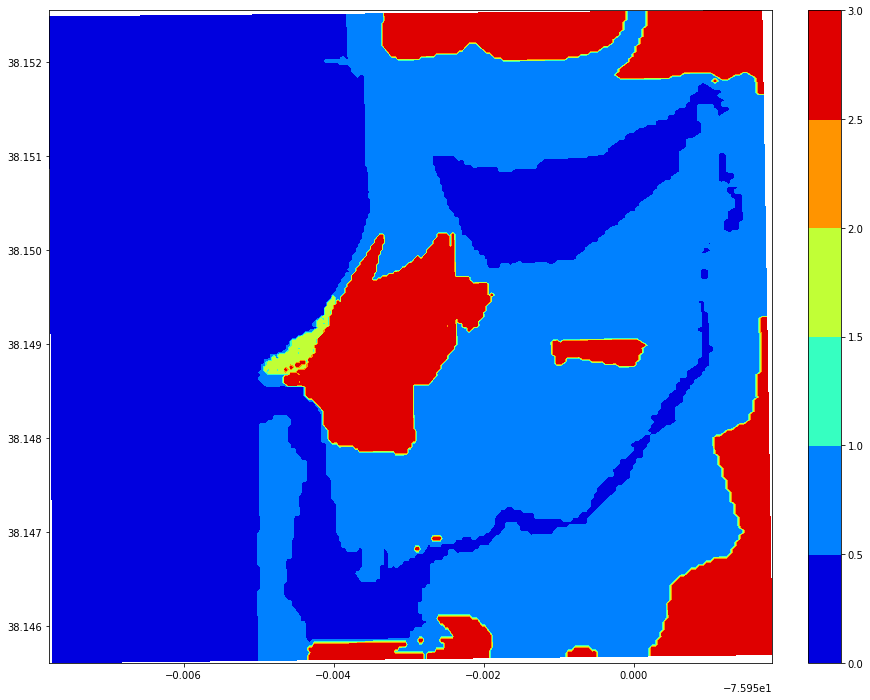

In [7]:
fig,ax = plt.subplots(figsize=(16,12))
levels = np.arange(0,3.1,.5)
plt.contourf(x,y,vege[:,:],cmap='jet',vmin=0,vmax=np.max(levels),levels=levels)
plt.colorbar(cmap='jet',pad=0.04)
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])
plt.show()

Bottom friction
===============

The short wave dissipation by bottom friction is modeled as

###### sw-bottom-friction

 \begin{array}{c} D_{f} =\frac{2}{3\pi } \rho f_{w} \left(\frac{\pi H_{rms} }{T_{m01} \sinh kh} \right)^{3} \end{array}

In `sw-bottom-friction` the `{f}_{w}` is the short-wave
friction coefficient. This value only affects the wave action equation
and is unrelated to bed friction in the flow equation. Studies
conducted on reefs (e.g.`Lowe2007`) indicate that`{f}_{w}` should be an order of magnitude (or more) larger than
the friction coefficient for flow (`{c}_{f}`) due to the
dependency of wave frictional dissipation rates on the frequency of
the motion.

The derivation of the short wave dissipation term is based
time-averaged instantaneous bottom dissipation using the Johnson
friction factor `{f}_{w}` of the bed shear stress:

###### sw-bottom-friction-0

   \begin{array}{c}{D}_{f} =\left|\tau u\right|=\frac{1}{2} \rho f_{w} \left|\tilde{u}\right|^{3} \end{array}

###### orbital-velocity

   \begin{array}{c}u_{orb} =\frac{\pi H_{rms} }{T_{p} \sinh (kh)} \end{array}

In this formulation `{T}_{p}` is the peak wave period,
`{H}_{rms}` is the root-mean-square wave height, `k` is
the wave number and `h` is the local water depth.

If we consider the slowly-varying dissipation in wave groups, we need
only to average over a single wave period and we can use a
monochromatic (regular wave) expression. If we want to have the
time-average dissipation over a full spectrum we get the best
approximation from considering a linear Gaussian
distribution.`Guza1985` give pragmatic expressions for both
cases.

For the monochromatic case:

###### orbital-velocity-monochomatic

   \begin{array}{c}\left\langle \left|\tilde{u}\right|^{3} \right\rangle =1.20\left\langle \left|\tilde{u}\right|^{2} \right\rangle ^{3/2} =1.20\left(\frac{1}{2} u_{orb}^{2} \right)^{3/2} =0.42u_{orb}^{3} \end{array}


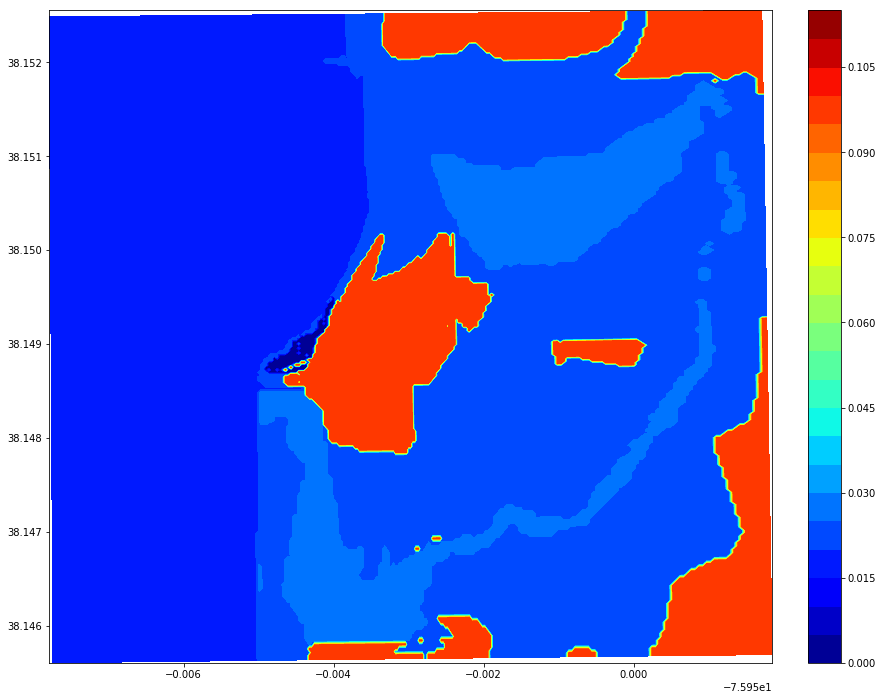

In [11]:
fig,ax = plt.subplots(figsize=(16,12))
#cmap = mpl.cm.get_cmap('jet')  
#normalize = mpl.colors.Normalize(vmin=.01, vmax=.03)
#colors = [cmap(normalize(value)) for value in bed.reshape(x1*y1)]
levels = np.arange(0,0.12,0.005)
plt.contourf(x,y,bed,cmap='jet',vmin=0, vmax=np.max(levels),levels=levels)
plt.colorbar(cmap='jet',pad=0.04)
ax.set_xlim([x.min(),x.max()])
ax.set_ylim([y.min(),y.max()])
plt.show()

#### Create 2d contour map

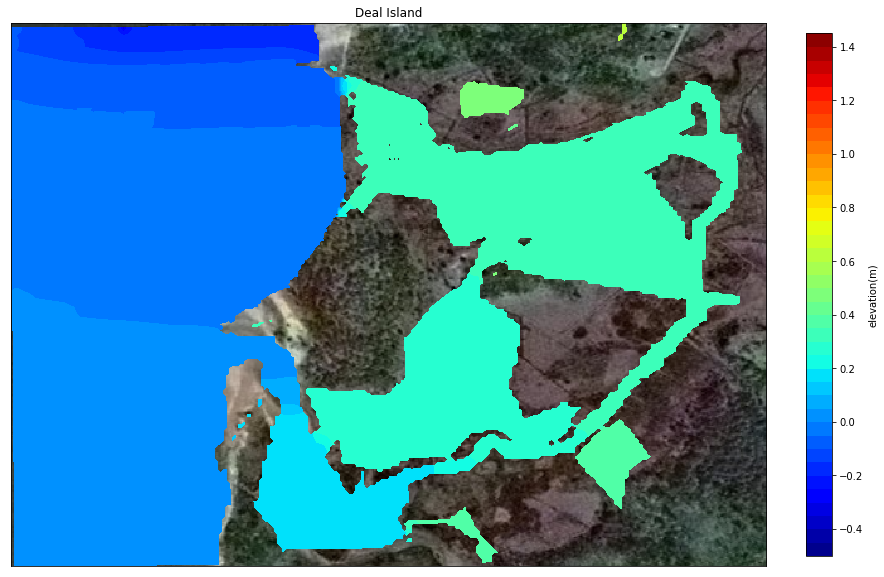

In [5]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.5,1.5,0.05)
xbeach.contour_map(x,y,z[0,:,:],zs[50,:,:],title,levels,lat1,lat2,lon1,lon2)

#### Find Observation Stations

In [9]:
station_x = [-75.953653,-75.953486,-75.953338,-75.952953] # s1,s2,s3,s4
station_y = [38.151136,38.151207,38.151208,38.151215]
gridx,gridy = [], []
for i in range(0,4):
    node = xbeach.find_node_ak(x,y,station_y[i],station_x[i])
    gridx.append(node[0])
    gridy.append(node[1])

#### Generate Model stations

In [10]:
water = xbeach.correct_hobo(str(hobos / 't1.mat'))
time = pd.date_range(start=pd.to_datetime('2018-09-12 19'),periods=int(len(zs[:,gridx[0],gridy[0]])),freq='20min')
model = pd.DataFrame({'date time':time,'s1':zs[:,gridx[0],gridy[0]],'s2':zs[:,gridx[1],gridy[1]],
                      's3':zs[:,gridx[2],gridy[2]],'s4':zs[:,gridx[3],gridy[3]]})

In [26]:
xbi.write_tide(root,water.index.values*360,water['S1'].astype('float')-.25,water['S4'].astype('float')-.25)

#### Generate 2d contour video with observation stations

In [27]:
import xbeach_inputs
reload(xbeach_inputs)
import xbeach_inputs as xbi
from xbeach import *

In [ ]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.3,2,0.1)
start,time = '2018091219', 280 
title = 'Deal Island '
xbeach.contour_stations(x,y,zs,water,gridx,gridy,model,start,time,title,levels,lat1,lat2,lon1,lon2)

In [ ]:
wl = glob.glob('WL*')
images = []
for ii in range(0,len(wl)):
    frames = Image.open(wl[ii])
    images.append(frames)
images[0].save('xbeach2d.gif',
    save_all=True,
    append_images=images[1:],
    delay=.1,
    duration=300,
    loop=0)
for f in glob.glob('WL*'):
    os.remove(f) 

<div align="middle"><img style="float:center;" src="xbeach2d.gif" width=1000px></div>

#### Generate 3d video

In [6]:
title = 'Deal Island'
levels = np.arange(-0.3,1.50001,0.1)
start,time = '2018091219',60
title = 'Deal Island '
xbeach.video_3d(x,y,z,h+zs,start,time,title,levels)

<div align="middle"><img style="float:center;" src="xbeach3d.gif" width=900px></div>

#### Generate Contour video with velocity vectors

In [7]:
lat1,lat2 = np.min(y),np.max(y)
lon1,lon2 = np.min(x),np.max(x)
title = 'Deal Island'
levels = np.arange(-0.3,1.5,0.1)
start,time = '2018091219',60
xbeach.map_velocity(x,y,zs,u,v,start,time,title,levels,lat1,lat2,lon1,lon2,gridspace=75)

<div align="middle"><img style="float:center;" src="xbeach_velocity.gif" width=900px></div>

#### Max velocity in the model

In [7]:
np.max(np.sqrt(np.square(u)+np.square(v)))

0.6554845707896482

# Other Parameters to explore

Wave shape
==========
             
The morphodynamic model considered is (short) wave averaged and resolves
hydrodynamics associated with the wave group time scale. As a result the
short wave shape is not solved for. However, as waves propagate from
deep water onto beaches, their surface form and orbital water motion
become increasingly non-linear because of the amplification of the
higher harmonics.

There are two wave forms implemented to take this non-linearity into
account:

 - A formulation of `Ruessink2012` based on a parameterization
   with the Ursell number. (keyword: `waveform` = *ruessink\_vanrijn*)

 - A formulation of `VanThieldeVries2009a` based on the parameterized
   wave shape model of `Rienecker1981` (keyword: `waveform` =
   vanthiel)


 \begin{array} U_{r} =\frac{3}{4} \frac{0.5H_{s} k}{(kh)^{3} }\end{array}

The value for the skewness and asymmetry is calculated with the use of a
Boltzmann sigmoid. The skewness and asymmetry are a function of
`\Psi`. In the formulation of `Ruessink2012` the
`{p}_{1:6}` are used as parameterized factors on the data set
of field observations.


   \begin{array}{c} {B=p_{1} +\frac{p_{2} -p_{1} }{1+\exp \frac{p_{3} -\log Ur}{p_{4} } } } \\ {\psi =-90+90\tanh (p_{5} /Ur^{p_{6} } )} \\ {} \\ {S_{k} =B\cos \psi {\; \; \; and\; \; \; }A_{s} =B\sin \psi } \end{array}


